In [41]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

bipolarCount = 0;
schizophreniaCount = 0;
schizophreniaAffectiveCount = 0;
controlCount = 0;

expression=pd.read_table("/Users/anchalbhardwaj/Downloads/Adjusted_expression_values.txt",index_col=0,usecols=list(range(0,547))).T
expression.index=expression.index.astype('int64')
expression.shape

individuals=pd.read_table("E-MTAB-8018.sdrf.txt",index_col=0)

df=individuals.join(expression,how='inner')

col_in_model=[2,3]
col_in_model.extend(list(range(28,47311)))
X=df.iloc[:,col_in_model]
X=pd.get_dummies(X) 

y=np.array(df['Characteristics[disease]'])
for i in range(y.size):
    if(y[i] == 'bipolar disorder'):
        bipolarCount += 1;
    elif(y[i] == 'schizophrenia'):
        schizophreniaCount += 1;
    elif(y[i] == 'schizoaffective disorder'):
        schizophreniaAffectiveCount += 1;
    elif(y[i] == 'normal'):
        controlCount += 1;

print("Bipolar Disorder #:", bipolarCount)
print("Schizophrenia #:", schizophreniaCount)
print("Schizophrenia Affective #", schizophreniaAffectiveCount)
print("Control #:", controlCount)
    
y=np.where(y!='normal',1,0)


def impute_by_mean(data):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean') 
    imp_mean.fit(data)
    return(pd.DataFrame(imp_mean.transform(data)))


no_of_na_before=np.array(X.isna().sum())
print('No. of NAs before imputation: ',sum(no_of_na_before[no_of_na_before!=0]))


X=impute_by_mean(X) 

no_of_na=np.array(X.isna().sum())
print('No. of NAs after imputation: ',sum(no_of_na[no_of_na!=0]))

Bipolar Disorder #: 84
Schizophrenia #: 58
Schizophrenia Affective # 13
Control #: 391
No. of NAs before imputation:  1
No. of NAs after imputation:  0


In [42]:
top_features=100

pvals=np.array(pd.read_csv('https://raw.githubusercontent.com/peterwu19881230/test_repo/master/pvals.csv')).ravel()

def rank_array(array):
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    return(ranks)

pval_ranks=rank_array(pvals)

selected=np.where(pval_ranks<top_features,True,False)

age_sex=X.iloc[:,[0,-1]]
gene_expression=X.iloc[:,1:-1]
selected_gene_expression=gene_expression.iloc[:,selected]

X=pd.concat([age_sex,selected_gene_expression],axis=1)

In [67]:
def my_inner_cv(X,y,model,cv,param_grid,test_size,random_state,train_test_boostrap=1):
  
  results=[]
  for b in range(train_test_boostrap):        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state,stratify=y)
        grid_search = GridSearchCV(model, param_grid=param_grid,cv=cv) 
        grid_search.fit(X_train, y_train)

        accuracy=accuracy_score(y_test,grid_search.best_estimator_.predict(X_test))
        result=[grid_search.best_estimator_,grid_search.best_params_,accuracy]
        results.append(result)
        
        random_state=random_state+1
        
  return(results)


def my_logistic_regression(X,y,cv=5,param_grid={},test_size=0.2,random_state=101,train_test_boostrap=1):
  model=LogisticRegression(solver='newton-cg',multi_class='ovr',penalty='l2')
  result=my_inner_cv(X,y,model,cv,param_grid,test_size,random_state,train_test_boostrap)
  return(result)

def my_lasso(X,y,cv=5,param_grid={},test_size=0.2,random_state=101,train_test_boostrap=1):
  model=LogisticRegression(multi_class='ovr',penalty='l1',solver='liblinear',max_iter=1000)
  result=my_inner_cv(X,y,model,cv,param_grid,test_size,random_state,train_test_boostrap)
  return(result)

In [57]:
cv=3
test_size=0.4
random_state=101
train_test_boostrap=15

In [58]:
C=[0.0001,0.001,0.01,0.1,1,10,100,1000,1000000]
result=my_lasso(X,y,cv=cv,test_size=test_size,param_grid={'C':C},random_state=random_state,train_test_boostrap=10)

hyper_params=[result[1] for result in result]
accuracies=[result[2] for result in result]

print('Bootstrapped best hyper parameters: ',hyper_params)
print('Bootstrapped accuracies= ',accuracies)
print('Average accuracy=',np.mean(accuracies))

Bootstrapped best hyper parameters:  [{'C': 10}, {'C': 10}, {'C': 10}, {'C': 10}, {'C': 1}, {'C': 10}, {'C': 10}, {'C': 10}, {'C': 1}, {'C': 1}]
Bootstrapped accuracies=  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Average accuracy= 1.0


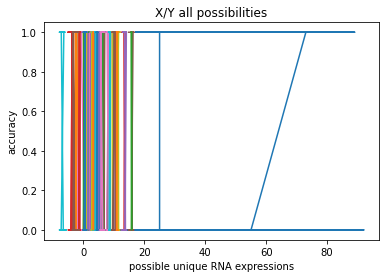

In [59]:
from matplotlib import pyplot as plt
plt.title("X/Y all possibilities") 
plt.xlabel("possible unique RNA expressions") 
plt.ylabel("accuracy") 
plt.plot(X,y) 
plt.show()

R squared training set -0.19
R squared test set -0.19
MSE training set 0.21
MSE test set 0.19


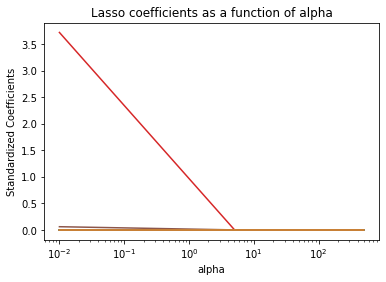

In [76]:
from sklearn.linear_model import Lasso
reg = Lasso(alpha=1)
reg.fit(X_train, y_train)
Lasso(alpha=1)
print('R squared training set', round(reg.score(X, y)*100, 2))
print('R squared test set', round(reg.score(X, y)*100, 2))

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
    
from sklearn.metrics import mean_squared_error

# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [77]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(X_train, y_train)
LassoCV(cv=5, max_iter=10000, random_state=0)

model.alpha_

0.0005123763054740824

In [78]:
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.0005123763054740824)

In [79]:
print(list(zip(lasso_best.coef_, X)))

[(0.00011210777264026495, 0), (-0.0031382723004331815, 47285), (0.0, 183), (-0.0, 191), (-0.006180460415316726, 194), (0.0, 969), (-0.0, 1278), (0.0, 1573), (0.0, 1759), (-0.0, 2042), (-0.0, 3270), (0.0, 3821), (-0.0, 4063), (0.01967743399826845, 4139), (-0.012272186222994308, 4550), (0.0, 5347), (0.0, 5560), (-0.0, 5942), (0.007557018232499018, 8861), (-0.0, 8930), (-0.0, 8956), (-0.0, 9487), (-0.03427824168260492, 10096), (7.541329785980292, 10423), (-0.0, 11533), (0.0, 11726), (-0.0, 12067), (0.0, 12068), (0.013492158385469133, 12139), (-0.0, 12431), (-0.0, 12434), (0.0, 12604), (0.0, 12775), (-0.0, 13221), (0.0, 13223), (-0.00018985385028148912, 14113), (-0.020060645338336, 14616), (-0.0, 15448), (-0.0, 16319), (-0.0, 16862), (-0.0, 17379), (-0.0, 17458), (-0.0, 17822), (-0.005639305150480905, 18236), (0.0, 18803), (0.0011946907030507743, 21433), (-0.0, 21697), (0.0, 21840), (0.0, 22958), (0.0, 25169), (-0.0, 25370), (0.0, 28517), (-0.0, 29289), (-0.0, 30085), (-0.00555820989200243

In [80]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 99.55
R squared test set 99.44


In [81]:
mean_squared_error(y_test, lasso_best.predict(X_test))

0.0010166242941437923

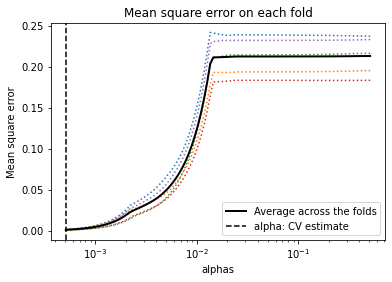

In [85]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

plt.show();

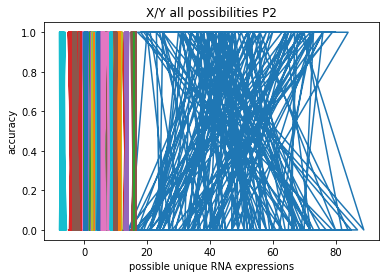

In [91]:
plt.title("X/Y all possibilities P2") 
plt.xlabel("possible unique RNA expressions") 
plt.ylabel("accuracy") 
plt.plot(X_train,y_train) 
plt.show()

In [116]:
#TRYING THE RIDGE METHOD


alphas = 40**np.linspace(10,-2,100)*0.6
alphas


array([6.29145600e+15, 4.02311154e+15, 2.57260426e+15, 1.64506815e+15,
       1.05194929e+15, 6.72675661e+14, 4.30146729e+14, 2.75060061e+14,
       1.75888905e+14, 1.12473279e+14, 7.19217531e+13, 4.59908224e+13,
       2.94091238e+13, 1.88058512e+13, 1.20255211e+13, 7.68979595e+12,
       4.91728891e+12, 3.14439166e+12, 2.01070124e+12, 1.28575569e+12,
       8.22184654e+11, 5.25751205e+11, 3.36194951e+11, 2.14981999e+11,
       1.37471606e+11, 8.79070927e+10, 5.62127494e+10, 3.59456000e+10,
       2.29856425e+10, 1.46983152e+10, 9.39893114e+09, 6.01020628e+09,
       3.84326462e+09, 2.45760000e+09, 1.57152795e+09, 1.00492354e+09,
       6.42604746e+08, 4.10917691e+08, 2.62763930e+08, 1.68026066e+08,
       1.07445336e+08, 6.87066035e+07, 4.39348744e+07, 2.80944348e+07,
       1.79651650e+07, 1.14879390e+07, 7.34603563e+06, 4.69746919e+06,
       3.00382654e+06, 1.92081598e+06, 1.22827799e+06, 7.85430173e+05,
       5.02248318e+05, 3.21165881e+05, 2.05371564e+05, 1.31326153e+05,
      

In [94]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 102)

Text(0, 0.5, 'weights')

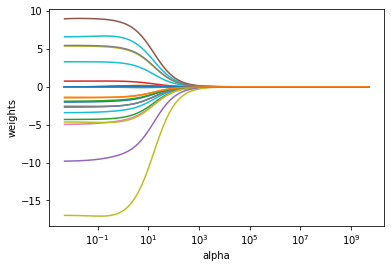

In [95]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [96]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [97]:
ridge2 = Ridge(alpha = 4, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

0        0.000055
47285   -0.001817
183      0.003297
191     -0.002935
194     -0.001192
           ...   
45799    4.288526
45925   -0.011269
46164   -0.000550
46165    0.010961
47214   -1.125839
Length: 102, dtype: float64
0.008344217904415245


In [99]:
ridge2 = Ridge(alpha = 0, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))           # Calculate the test MSE

0        3.040808e-11
47285    3.422954e-10
183     -7.841560e-08
191     -2.311958e-08
194      1.458322e-08
             ...     
45799    4.410420e-05
45925    1.457759e-08
46164   -1.275069e-08
46165    4.544037e-08
47214    1.776936e-03
Length: 102, dtype: float64
4.952868525121838e-16


/Users/anchalbhardwaj/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.06632e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [100]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.005

In [101]:
ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))

1.9605192190030596e-07

In [102]:
ridge4.fit(X, y)
pd.Series(ridge4.coef_, index = X.columns)

0        4.938062e-07
47285   -6.341417e-06
183      3.212757e-04
191      2.920820e-04
194     -6.024822e-05
             ...     
45799    5.454626e+00
45925    2.504412e-04
46164   -4.936669e-06
46165    1.259871e-04
47214   -1.452828e+00
Length: 102, dtype: float64

In [107]:
pred = ridge4.predict(X_test)
print(mean_squared_error(y_test, pred))   

9.831598076480562e-08


9.831598076480562e-08


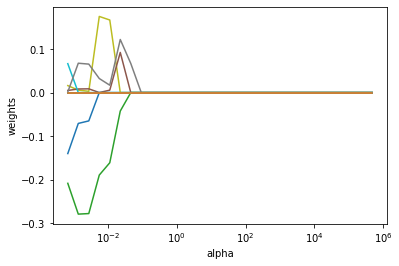

In [138]:
alphas = 30**np.linspace(5,-1,30)*0.01
alphas

from sklearn.preprocessing import scale 
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

pred = ridge4.predict(X_test)
print(mean_squared_error(y_test, pred))  


Coefficients A: 7.7, Intercept b: 2.9
Coefficients A: 8.02, Intercept b: 2.9


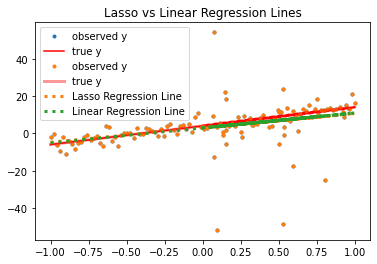

In [148]:
#general looking at lasso vs linear regression
#https://h1ros.github.io/posts/lasso-regression/
from sklearn.linear_model import Lasso, LinearRegression

# Dummy Data used for linear regression
a = 10
b = 4
n = 100
sigma = 3
e1 = sigma * np.random.randn(n) 
x1 = np.linspace(-1, 1, num=n)
y1 = a * x1 + b + e1

# Create outliers to see the robustness of lasso regression
n2 = 20
e2 = sigma * 10 * np.random.randn(n2) 
x2 = np.random.random_sample(size=n2)
y2 = a * x2 + b + e2

# Add two data
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])
plt.plot(x, y, '.', label='observed y');
plt.plot(x, a * x + b, 'r', label='true y');
plt.legend();


reg = Lasso(alpha=0.1)
reg.fit(x.reshape(-1, 1), y)  

print(f'Coefficients A: {reg.coef_[0]:.3}, Intercept b: {reg.intercept_:.2}')

lin_reg = LinearRegression()
lin_reg.fit(x.reshape(-1, 1), y);
print(f'Coefficients A: {lin_reg.coef_[0]:.3}, Intercept b: {lin_reg.intercept_:.2}')

plt.plot(x, y, '.', label='observed y');
plt.plot(x, a * x + b, 'r', label='true y', lw=3, alpha=0.4);
plt.plot(x, reg.coef_[0] * x + reg.intercept_ , label='Lasso Regression Line', c='C1', ls='dotted', lw=3)
plt.plot(x, lin_reg.coef_[0] * x + lin_reg.intercept_ , label='Linear Regression Line', c='C2', ls='dotted', lw=3)
plt.legend();
plt.title('Lasso vs Linear Regression Lines');